In [15]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as transforms

In [16]:
train_data = np.load('flower_imgs.npy')
labels = np.load('flower_labels.npy')
x_train, x_test, y_train, y_test = train_test_split(train_data, labels,
                                                    stratify=labels, 
                                                    test_size=0.10)

In [17]:
# x_train, x_test, y_train, y_test = x_train.astype(np.float32), x_test.astype(np.float32), y_train.astype(np.float32), y_test.astype(np.float32) 

1


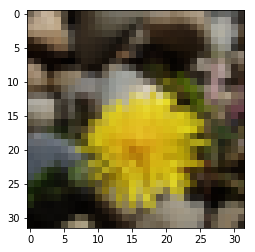

In [18]:
plt.imshow(x_train[590])
print(y_train[590])

In [19]:
# h = torch.randn(5, 7, dtype=torch.double)
# u = torch.div(h,255)
# print(h)
# print(u)

In [20]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [29]:
class ImgLoader(Dataset):
    def __init__(self, x, y,iscuda=False):
        self.X = np.array(x, dtype = np.float32)
        self.y = np.array(y, dtype = np.float32)
#         self.cuda = iscuda
    
    def __getitem__(self, index):
        x_val = self.X[index]
#         x_val = torch.div(torch.from_numpy(x_val).permute(2, 1, 0), 255.0)
        x_val = torch.div(torch.from_numpy(x_val).permute(2, 1, 0), 255.0)
        y_val = torch.from_numpy(np.array([self.y[index]]))
#         normal=transforms.Compose([transforms.ToPILImage(),
# #                                    transforms.ToTensor(),
#                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
#                              ])
#         x_val = normal(x_val)
        
#         if self.cuda:
#             x_val = x_val.cuda()
#             y_val = y_val.cuda()
        return x_val, y_val

    def __len__(self):
        return len(self.X)

In [22]:
class ConvClassifier(nn.Module):
    def __init__(self):
        super(ConvClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 5, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(5)
        self.conv2 = nn.Conv2d(5, 16, kernel_size=3, padding=1, stride=1)
        self.bn2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, padding=1, stride=1)
        self.bn3 = nn.BatchNorm2d(32)

        self.conv4 = nn.Conv2d(32, 16, kernel_size=3, padding=1, stride=1)
        self.bn4 = nn.BatchNorm2d(16)

        self.conv5 = nn.Conv2d(16, 16, kernel_size=5, padding=1, stride=2)
        self.bn5 = nn.BatchNorm2d(16)
        self.fc1 = nn.Linear(3600, 10)
        self.fc2 = nn.Linear(10, 10)
        
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
        
#     def forward(self, x):
#         self.conv_l1 = self.conv1(x)
#         self.conv_l1 = self.bn1(self.conv_l1)
        
#         self.conv_l2 = F.relu(self.conv2(self.conv_l1))
#         self.conv_l2 = self.bn2(self.conv_l2)
        
#         self.conv_l3 = F.relu(self.conv3(self.conv_l2))
#         self.conv_l3 = self.bn3(self.conv_l3)

#         self.conv_l4 = F.relu(self.conv4(self.conv_l3))
#         self.conv_l4 = self.bn4(self.conv_l4)

#         self.conv_l5 = F.relu(self.conv5(self.conv_l4))
#         self.conv_l5 = self.bn5(self.conv_l5)
# #         self.conv_l5

#         self.fc_l1 = self.conv_l5.view(-1, self.num_flat_features(self.conv_l5))
#         self.fc_l1 = F.relu(self.fc1(self.fc_l1))
#         self.fc_l2 = self.fc2(self.fc_l1) 
        
#         return F.log_softmax(self.fc_l2)

In [23]:
use_cuda = torch.cuda.is_available()
img_loader = ImgLoader(x_train, y_train, use_cuda)

In [25]:
trainloader = DataLoader(img_loader, batch_size = 5, shuffle=True, num_workers=4)

In [26]:
def eval(model):
    model.train(False)
    count = 0
    for x,y in zip(x_test,y_test):
        x = torch.from_numpy(np.array([x])).permute(0, 3, 1, 2)
        x = x.type(torch.FloatTensor)
        if use_cuda:
            x = x.cuda()
        out = model(Variable(x))
#         print(out.shape)
        label = np.argmax(out.data.cpu().numpy()) # needs to be optimized
        if y == label:
            count += 1
    print(count * 1.0 / len(x_test))

In [27]:
epochs = 10
criterion = nn.CrossEntropyLoss()
net = ConvClassifier()
if use_cuda:
    net = net.cuda()
    
    

In [28]:
optimizer = optim.SGD(params=net.parameters(), lr=0.003)

for epoch in range(epochs):
    losses = []
    net.train(True)
    for i ,(x, y) in enumerate(trainloader):
        if use_cuda:
            x = x.cuda()
            y = y.cuda()
        optimizer.zero_grad()

        inputs =  Variable(x)
        output = net(inputs)
        targets = Variable(y.squeeze(1))
        targets = targets.type(torch.LongTensor)

        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()
        losses.append(loss.data[0])
#         break
#     break
    if (epoch+1) % 1 == 0:
        print('Epoch %d Loss %.4f  ' % (epoch+1, np.average(losses)))
        print('test accuracy')
        eval(net)

NotImplementedError: 